In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score,precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Part 1: Data exploration

In [2]:
data = pd.read_csv('European_bank_marketing.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit,Ethnicity_African
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


In [3]:
#Drop duplicate values
data = data.drop_duplicates()
data.shape

(41178, 22)

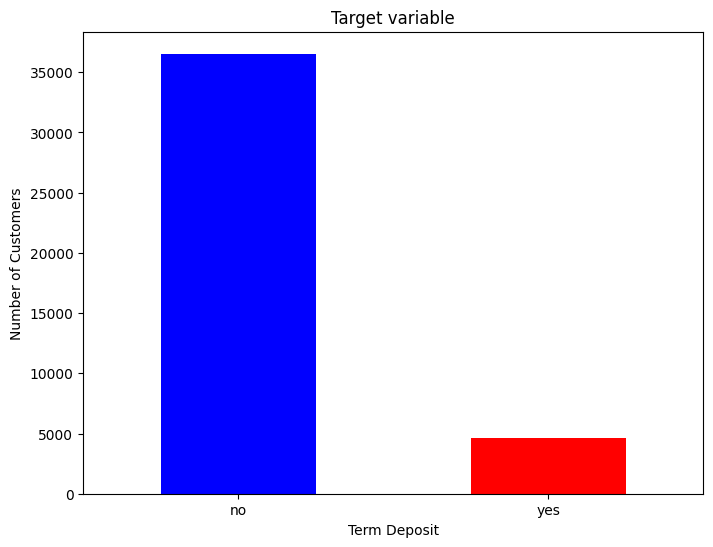

In [4]:
#Display ratio of no/yes for target variable, term_deposits
subscription_counts = data['term_deposit'].value_counts()
subscription_counts.index = ['no', 'yes']

plt.figure(figsize=(8, 6))
subscription_counts.plot(kind='bar',color=['blue', 'red'])  
plt.title('Target variable')
plt.xlabel('Term Deposit')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()
#Note: Data is imbalanced

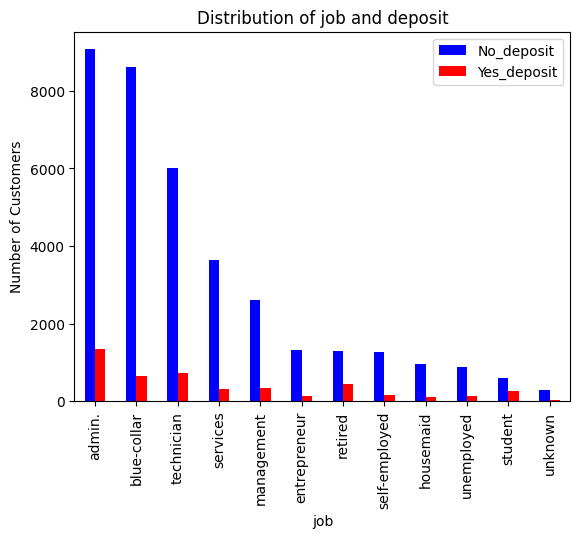

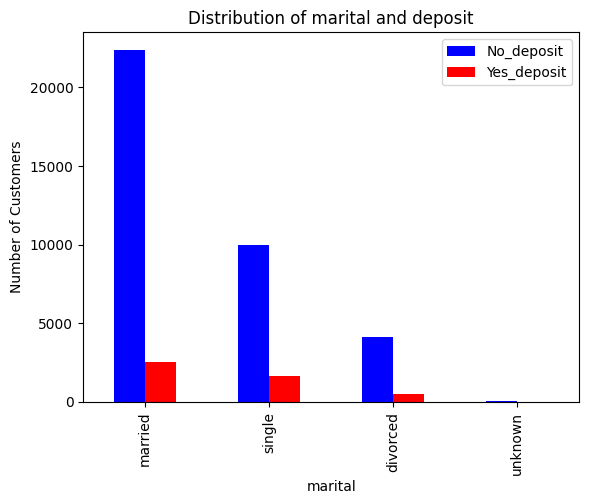

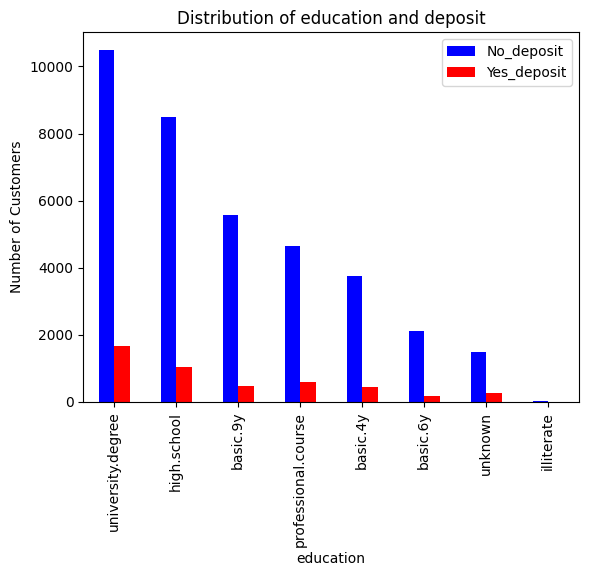

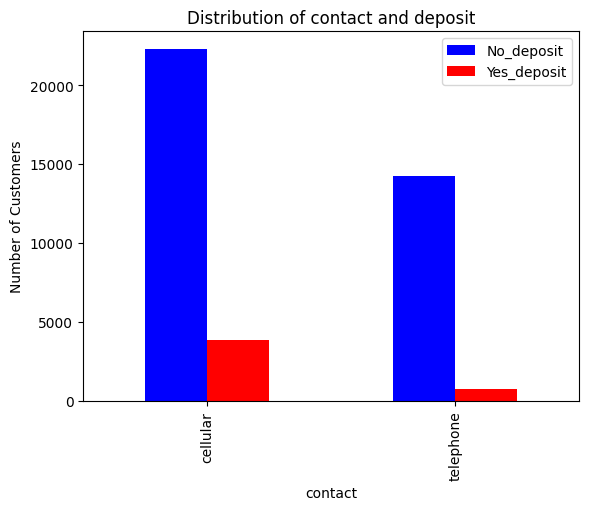

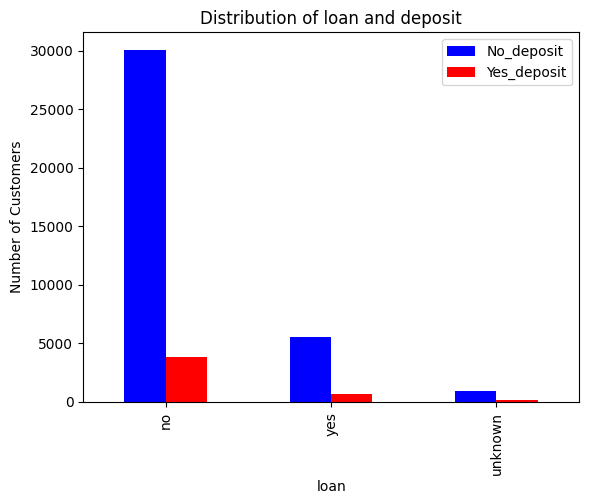

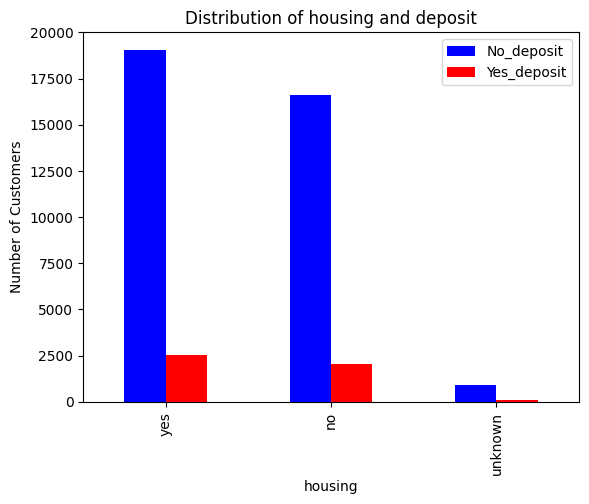

In [5]:
#Show outcomes for catagorical variabels 
def plot_bar(column):
    #Create a temporary DataFrame
    temp_df = pd.DataFrame()
    
    #Calculate the number of classes based on the value of term_deposit
    temp_df['No_deposit'] = data[data['term_deposit'] == 0][column].value_counts()
    temp_df['Yes_deposit'] = data[data['term_deposit'] == 1][column].value_counts()
    
    #Draw bar charts
    temp_df.plot(kind='bar',color=['blue', 'red'])
    plt.xlabel(f'{column}')
    plt.ylabel('Number of Customers')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show()

plot_bar('job')
plot_bar('marital')
plot_bar('education')
plot_bar('contact')
plot_bar('loan')
plot_bar('housing')


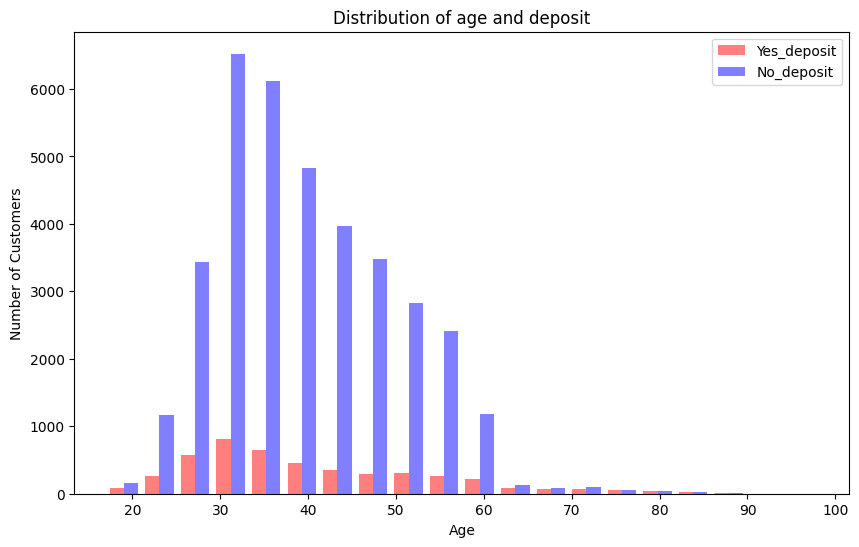

In [6]:
#Plotting the relationship between age and term deposit subscription
plt.figure(figsize=(10, 6))
plt.hist([data[data['term_deposit']==1]['age'], data[data['term_deposit']==0]['age']], 
         bins=20, alpha=0.5, label=['Yes_deposit', 'No_deposit'],color=['red','blue', ])
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.title('Distribution of age and deposit')
plt.legend()
plt.show()

In [7]:
#Calculate the correlation matrix
corr = data.corr()

#Display the visual effect of the correlation matrix
corr.style.background_gradient(cmap='PuBu')

/var/folders/rm/zw5ycl5x75vd7k4_ycrpc8780000gn/T/ipykernel_55102/66218988.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit,Ethnicity_African
age,1.000000,-0.000803,0.004626,-0.034382,0.024381,-0.000248,0.001003,0.129079,0.010846,-0.017613,0.030383,-0.008237
duration,-0.000803,1.000000,-0.071748,-0.047561,0.020610,-0.027964,0.005296,-0.008130,-0.032882,-0.044694,0.405303,0.050139
campaign,0.004626,-0.071748,1.000000,0.052600,-0.079171,0.150759,0.127820,-0.013663,0.135145,0.144102,-0.066350,-0.000700
pdays,-0.034382,-0.047561,0.052600,1.000000,-0.587509,0.271066,0.078921,-0.091370,0.296949,0.372660,-0.324950,-0.040892
previous,0.024381,0.020610,-0.079171,-0.587509,1.000000,-0.420592,-0.203199,-0.050932,-0.454576,-0.501415,0.230206,0.032214
emp.var.rate,-0.000248,-0.027964,0.150759,0.271066,-0.420592,1.000000,0.775284,0.196261,0.972245,0.906953,-0.298297,-0.048419
cons.price.idx,0.001003,0.005296,0.127820,0.078921,-0.203199,0.775284,1.000000,0.059157,0.688173,0.521941,-0.136136,-0.022142
cons.conf.idx,0.129079,-0.008130,-0.013663,-0.091370,-0.050932,0.196261,0.059157,1.000000,0.277865,0.100685,0.054797,0.008458
euribor3m,0.010846,-0.032882,0.135145,0.296949,-0.454576,0.972245,0.688173,0.277865,1.000000,0.945148,-0.307748,-0.050280
nr.employed,-0.017613,-0.044694,0.144102,0.372660,-0.501415,0.906953,0.521941,0.100685,0.945148,1.000000,-0.354676,-0.058017


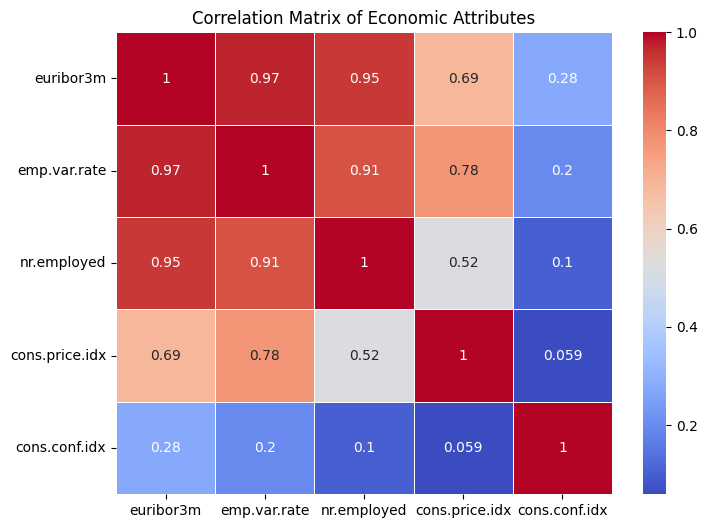

In [8]:
#Selecting the specific economic attributes to analyze
economic_attributes = ['euribor3m', 'emp.var.rate', 'nr.employed', 'cons.price.idx', 'cons.conf.idx']

#Calculating the correlation matrix for the selected economic attributes
economic_corr_matrix = data[economic_attributes].corr()

# Generate a heatmap for the correlation matrix of the economic attributes
plt.figure(figsize=(8, 6))
sns.heatmap(economic_corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Economic Attributes')
plt.show()

In [9]:
#Drop irrelevant columns
data = data.drop(columns=['emp.var.rate', 'nr.employed', 'cons.price.idx'])

In [10]:
data.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.conf.idx,euribor3m,term_deposit,Ethnicity_African
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-50.8,1.028,1,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-50.8,1.028,0,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-50.8,1.028,0,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-50.8,1.028,1,0
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,239,3,999,1,failure,-50.8,1.028,0,0


In [11]:
#Calculate the correlation matrix
corr = data.corr()

#Display the visual effect of the correlation matrix
corr.style.background_gradient(cmap='PuBu')

/var/folders/rm/zw5ycl5x75vd7k4_ycrpc8780000gn/T/ipykernel_55102/66218988.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


,age,duration,campaign,pdays,previous,cons.conf.idx,euribor3m,term_deposit,Ethnicity_African
age,1.000000,-0.000803,0.004626,-0.034382,0.024381,0.129079,0.010846,0.030383,-0.008237
duration,-0.000803,1.000000,-0.071748,-0.047561,0.020610,-0.008130,-0.032882,0.405303,0.050139
campaign,0.004626,-0.071748,1.000000,0.052600,-0.079171,-0.013663,0.135145,-0.066350,-0.000700
pdays,-0.034382,-0.047561,0.052600,1.000000,-0.587509,-0.091370,0.296949,-0.324950,-0.040892
previous,0.024381,0.020610,-0.079171,-0.587509,1.000000,-0.050932,-0.454576,0.230206,0.032214
cons.conf.idx,0.129079,-0.008130,-0.013663,-0.091370,-0.050932,1.000000,0.277865,0.054797,0.008458
euribor3m,0.010846,-0.032882,0.135145,0.296949,-0.454576,0.277865,1.000000,-0.307748,-0.050280
term_deposit,0.030383,0.405303,-0.066350,-0.324950,0.230206,0.054797,-0.307748,1.000000,0.144139
Ethnicity_African,-0.008237,0.050139,-0.000700,-0.040892,0.032214,0.008458,-0.050280,0.144139,1.000000


In [12]:
#Drop duration column, because information would not be available before customer decision
data = data.drop(columns=['duration'])

In [13]:
#Calculate the correlation matrix
corr = data.corr()

#Display the visual effect of the correlation matrix
corr.style.background_gradient(cmap='PuBu')

/var/folders/rm/zw5ycl5x75vd7k4_ycrpc8780000gn/T/ipykernel_55102/66218988.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


,age,campaign,pdays,previous,cons.conf.idx,euribor3m,term_deposit,Ethnicity_African
age,1.000000,0.004626,-0.034382,0.024381,0.129079,0.010846,0.030383,-0.008237
campaign,0.004626,1.000000,0.052600,-0.079171,-0.013663,0.135145,-0.066350,-0.000700
pdays,-0.034382,0.052600,1.000000,-0.587509,-0.091370,0.296949,-0.324950,-0.040892
previous,0.024381,-0.079171,-0.587509,1.000000,-0.050932,-0.454576,0.230206,0.032214
cons.conf.idx,0.129079,-0.013663,-0.091370,-0.050932,1.000000,0.277865,0.054797,0.008458
euribor3m,0.010846,0.135145,0.296949,-0.454576,0.277865,1.000000,-0.307748,-0.050280
term_deposit,0.030383,-0.066350,-0.324950,0.230206,0.054797,-0.307748,1.000000,0.144139
Ethnicity_African,-0.008237,-0.000700,-0.040892,0.032214,0.008458,-0.050280,0.144139,1.000000


In [14]:
#Removing rows with 'unknown' values in specific columns
unknown_indices = data[(data['loan'] == 'unknown') | (data['housing'] == 'unknown') | (data['marital'] == 'unknown')].index
data = data.drop(index=unknown_indices)

#Show the shape of the dataset after removals
data.shape

(40109, 18)

In [15]:
#Count the number of people in each category under all classification features
category_counts = {feature: data[feature].value_counts().to_dict() for feature in data.columns if data[feature].dtype == 'object'}

In [16]:
unknown_indexes = data[data['default'] == 'unknown'].index
if len(unknown_indexes) > 0:
    data.at[unknown_indexes[0], 'default'] = 'yes'
    data.loc[unknown_indexes[1:], 'default'] = 'no'
data['default'].value_counts()


no     40105
yes        4
Name: default, dtype: int64

In [17]:
category_counts = {feature: data[feature].value_counts().to_dict() for feature in data.columns if data[feature].dtype == 'object'}

In [18]:
#Selecting the variables mentioned
variables_to_scale = ['campaign', 'age', 'cons.conf.idx', 'euribor3m']

#Creating the scaler
scaler = StandardScaler()

#Fitting the scaler and transform the selected variables
data[variables_to_scale] = scaler.fit_transform(data[variables_to_scale])

#Correcting the provided code with proper Python syntax for mapping
data['contact'] = data['contact'].map({'cellular': 1, 'telephone': 0})
data['housing'] = data['housing'].map({'yes': 1, 'no': 0})
data['loan'] = data['loan'].map({'yes': 1, 'no':0})
data['default'] = data['default'].map({'yes': 1, 'no':0})

#Replace 999 in 'pdays' with 0, indicating no previous contact
data['pdays'] = data['pdays'].replace(999, 0)

#Convert 'previous' to a binary indicator where 1 indicates there was a contact and 0 otherwise
data['previous'] = data['previous'].apply(lambda x: 1 if x > 0 else 0)

#Map 'poutcome' to a binary indicator where 1 indicates success and 0 otherwise (including 'nonexistent' and 'failure')
data['poutcome'] = data['poutcome'].map({'nonexistent': 0, 'failure': 0, 'success': 1})

#Get dummies
data = pd.concat([data, pd.get_dummies(data['job'], prefix='job')], axis=1)
data = pd.concat([data, pd.get_dummies(data['month'], prefix='month')], axis=1)
data = pd.concat([data, pd.get_dummies(data['day_of_week'], prefix='day_of_week')], axis=1)
data = pd.concat([data, pd.get_dummies(data['education'], prefix='day_of_week')], axis=1)
data = pd.concat([data, pd.get_dummies(data['marital'], prefix='marital')], axis=1)

In [19]:
#Delete the original classification feature column that has been replaced by the one hot code
columns_already_encoded = ['job', 'month', 'day_of_week', 'education','marital']
data_final = data.drop(columns=columns_already_encoded, errors='ignore')

In [20]:
print(data_final.shape)
data_final.head()

(40109, 51)


,age,default,housing,loan,contact,campaign,pdays,previous,poutcome,cons.conf.idx,...,day_of_week_basic.6y,day_of_week_basic.9y,day_of_week_high.school,day_of_week_illiterate,day_of_week_professional.course,day_of_week_university.degree,day_of_week_unknown,marital_divorced,marital_married,marital_single
0,1.532958,0,0,0,0,-0.56701,0,0,0,0.88748,...,0,0,0,0,0,0,0,0,1,0
1,1.628920,1,0,0,0,-0.56701,0,0,0,0.88748,...,0,0,1,0,0,0,0,0,1,0
2,-0.290313,0,1,0,0,-0.56701,0,0,0,0.88748,...,0,0,1,0,0,0,0,0,1,0
3,-0.002428,0,0,0,0,-0.56701,0,0,0,0.88748,...,1,0,0,0,0,0,0,0,1,0
4,1.532958,0,0,1,0,-0.56701,0,0,0,0.88748,...,0,0,1,0,0,0,0,0,1,0


In [21]:
#Calculate the correlation matrix
corr = data.corr()

#Display the visual effect of the correlation matrix
corr.style.background_gradient(cmap='PuBu')

/var/folders/rm/zw5ycl5x75vd7k4_ycrpc8780000gn/T/ipykernel_55102/66218988.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


,age,default,housing,loan,contact,campaign,pdays,previous,poutcome,cons.conf.idx,euribor3m,term_deposit,Ethnicity_African,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,day_of_week_basic.4y,day_of_week_basic.6y,day_of_week_basic.9y,day_of_week_high.school,day_of_week_illiterate,day_of_week_professional.course,day_of_week_university.degree,day_of_week_unknown,marital_divorced,marital_married,marital_single
age,1.000000,0.005726,-0.001603,-0.007116,-0.005565,0.004138,0.019220,0.017470,0.037573,0.129457,0.009825,0.030420,-0.007884,-0.103135,-0.023977,0.030976,0.084994,0.061907,0.440804,-0.001233,-0.065117,-0.199702,-0.064018,-0.004116,0.048927,0.013726,0.065339,0.045194,-0.042933,-0.009139,0.009327,-0.068379,0.029714,0.051511,0.044463,0.007947,0.019576,-0.021659,0.018721,-0.024274,0.242798,0.009999,-0.037829,-0.106173,0.017232,0.002825,-0.070951,0.068603,0.166858,0.272565,-0.413104
default,0.005726,1.000000,-0.005747,-0.004285,0.002360,-0.004759,-0.001636,0.003308,-0.001857,0.006166,0.006409,-0.003559,-0.001739,-0.005824,-0.005372,-0.001911,-0.001620,-0.002762,-0.002082,-0.001882,0.005207,-0.001470,0.009059,0.014573,-0.000890,-0.002613,0.009761,-0.000663,-0.004598,-0.003825,-0.001157,-0.001773,0.004985,-0.001325,-0.001182,-0.004833,0.001060,-0.005143,0.013931,-0.004955,-0.003349,-0.002420,-0.004142,0.006363,-0.000212,0.011160,-0.006469,-0.002089,-0.003546,0.008041,-0.006249
housing,-0.001603,-0.005747,1.000000,0.045882,0.082854,-0.010952,0.005108,0.025776,0.012930,-0.034282,-0.060494,0.011849,0.001593,0.009859,-0.014821,0.004367,-0.004429,-0.008046,-0.001934,0.000313,-0.004692,0.004873,0.010025,0.008963,-0.002647,0.029812,0.025780,0.007183,-0.001481,-0.055412,0.013944,-0.022399,0.032483,0.003585,0.007079,-0.015406,0.011742,0.011887,-0.010294,0.001338,-0.012415,-0.007152,-0.001916,-0.006988,0.000790,0.013515,0.013564,-0.008524,-0.002055,-0.011973,0.014447
loan,-0.007116,-0.004285,0.045882,1.000000,0.012126,0.005521,-0.002616,-0.000230,-0.000512,-0.013284,-0.000575,-0.004516,0.004291,0.020011,-0.005655,-0.005706,-0.002538,-0.001100,-0.006767,-0.007536,-0.000266,0.004626,-0.006538,-0.002083,0.003011,0.001244,-0.002042,0.006908,0.015304,-0.007982,-0.003948,0.000430,-0.004710,-0.009445,-0.002437,0.006786,0.006663,-0.001875,-0.009527,-0.002046,-0.001438,-0.005090,-0.006443,-0.000409,0.000654,-0.000513,0.012466,-0.007384,-0.005038,-0.001481,0.005142
contact,-0.005565,0.002360,0.082854,0.012126,1.000000,-0.077583,0.097942,0.240835,0.111414,-0.250965,-0.397604,0.143042,0.026107,0.057445,-0.092564,-0.019567,-0.010547,0.010173,0.035626,-0.003589,-0.035899,0.039732,0.048595,-0.008346,-0.022912,0.158859,0.280525,0.025879,0.203666,-0.384057,0.060356,-0.344513,0.180727,0.040692,0.051276,-0.041000,0.015875,0.041037,-0.004628,-0.013113,-0.049300,-0.043893,-0.054999,-0.013762,0.008677,0.022430,0.101944,-0.019994,-0.004466,-0.063805,0.072446
campaign,0.004138,-0.004759,-0.010952,0.005521,-0.077583,1.000000,-0.041576,-0.088090,-0.050886,-0.014187,0.135587,-0.065449,-0.001643,0.011934,-0.000882,-0.004110,0.001963,-0.008964,-0.006029,0.006749,0.001662,-0.024501,0.002270,-0.000324,0.001725,-0.058273,0.015254,-0.011706,0.099284,0.070236,-0.015311,-0.033219,-0.079308,-0.049013,-0.034015,0.027209,0.013247,0.005349,-0.024454,-0.021357,0.004022,-0.001499,-0.003976,-0.000478,-0.002216,0.002189,-0.000365,0.001113,0.004729,0.003399,-0.007009
pdays,0.019220,-0.001636,0.005108,-0.002616,0.097942,-0.041576,1.000000,0.412294,0.738979,0.065091,-0.251457,0.265988,0.036434,0.022905,-0.053691,-0.015833,0.000326,-0.003662,0.055583,-0.013819,-0.027765,0.092051,-0.001175,0.017092,0.004213,0.003997,0.000811,0.068239,-0.029442,-0.020030,0.074792,-0.055228,0.004010,0.106080,0.

## Part 2: Use logistic regression to predict target variable

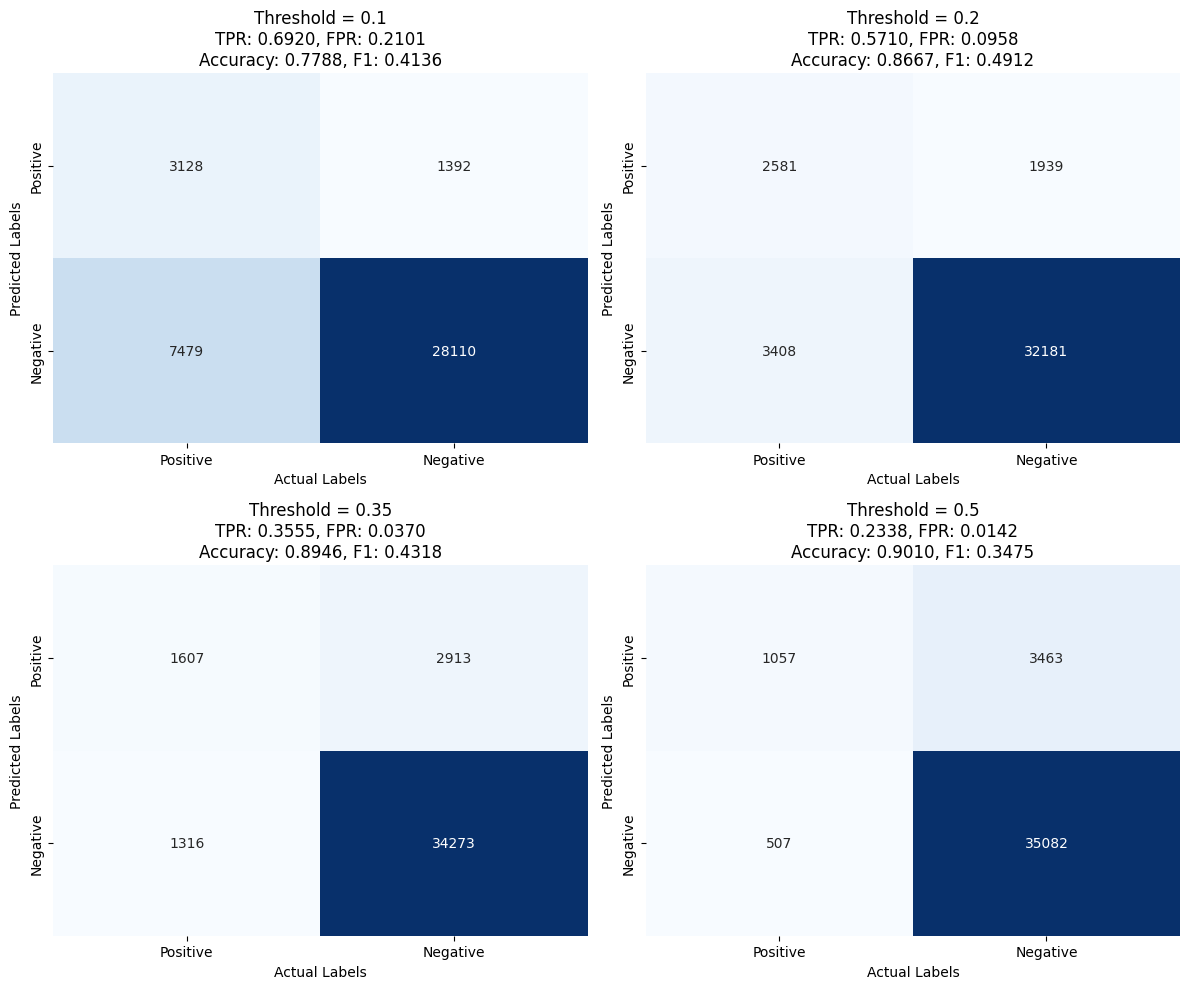

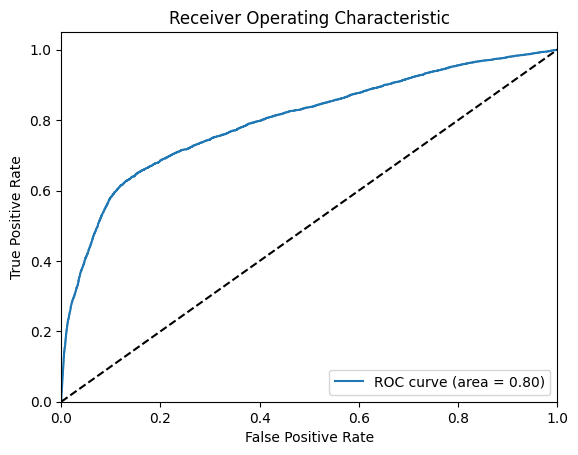

AUC (Area Under Curve): 0.7990


In [22]:
#Dependent Variable
y = data_final['term_deposit']
#Independent Variable
X = data_final.drop(['term_deposit'], axis=1)

#Initializing and fitting the logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X, y)

#Predicting probabilities on the entire dataset
y_proba = logreg.predict_proba(X)[:, 1]

#Defining different probability thresholds
thresholds = [0.1, 0.2, 0.35, 0.5]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, threshold in enumerate(thresholds):
    #Determining the predicted category based on the threshold
    y_pred_threshold = (y_proba >= threshold).astype(int)
    # Computing the confusion matrix
    cm = confusion_matrix(y, y_pred_threshold)
    #Reordering the confusion matrix to have positive class first
    reordered_cm = cm[[1, 0], :][:, [1, 0]]

    #Calculating TPR, FPR, Accuracy, and F1 Score
    tp = reordered_cm[0, 0]
    fn = reordered_cm[0, 1]
    fp = reordered_cm[1, 0]
    tn = reordered_cm[1, 1]
    tpr = tp / (tp + fn) if tp + fn else 0
    fpr = fp / (fp + tn) if fp + tn else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * tp / (2 * tp + fp + fn) if 2 * tp + fp + fn else 0

    #Plotting the confusion matrix
    sns.heatmap(reordered_cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx], cbar=False)
    axes[idx].set_xlabel('Actual Labels')
    axes[idx].set_ylabel('Predicted Labels')
    axes[idx].set_title(f'Threshold = {threshold}\nTPR: {tpr:.4f}, FPR: {fpr:.4f}\nAccuracy: {accuracy:.4f}, F1: {f1:.4f}')
    axes[idx].set_xticklabels(['Positive', 'Negative'])
    axes[idx].set_yticklabels(['Positive', 'Negative'])

plt.tight_layout()
plt.show()

#Plotting the ROC curve and calculating the AUC
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC (Area Under Curve): {roc_auc:.4f}")


Use cross validation to test out of sample predictability. 70% training data and 30% test data

Cross-validated Accuracy on Training Set: 0.9019 (±0.0028)


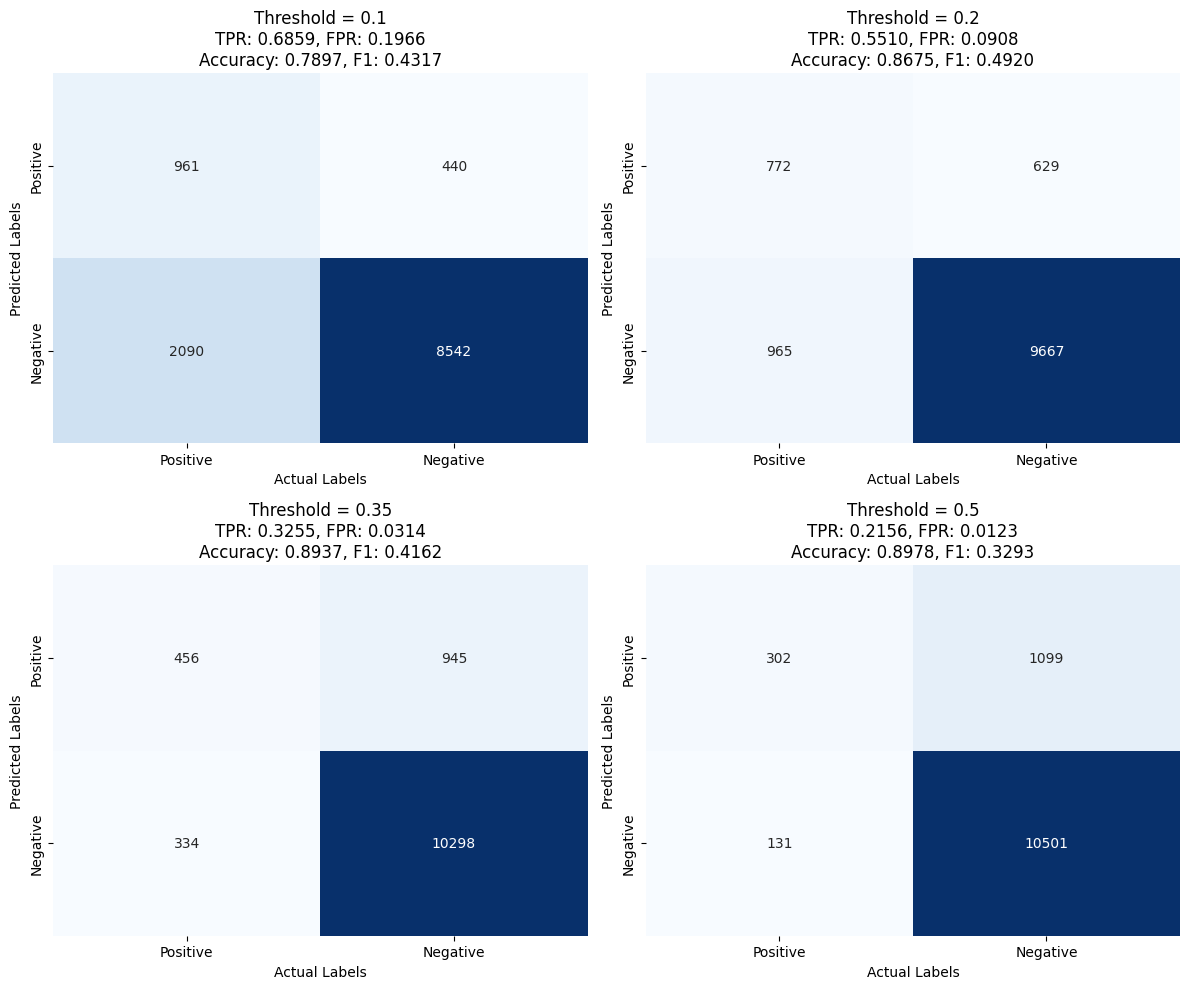

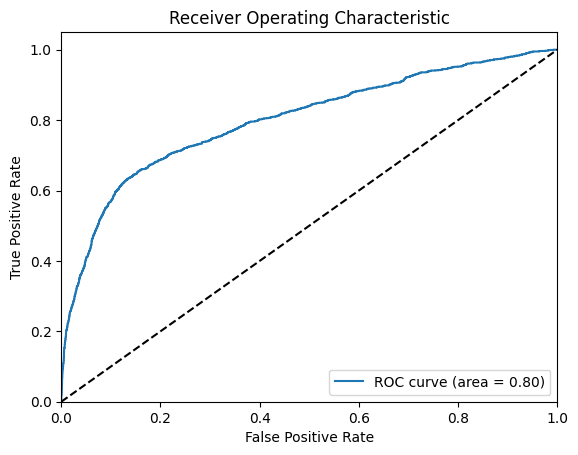

AUC (Area Under Curve): 0.7996


In [23]:
# Splitting the dataset into training and test sets for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initializing the logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Performing 5-fold cross-validation on the training set
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(logreg, X_train, y_train, cv=cv_strategy, scoring='accuracy')
print(f"Cross-validated Accuracy on Training Set: {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f})")

# Fitting the model on the entire training set for final evaluation
logreg.fit(X_train, y_train)

# Predicting probabilities on the test set
y_proba = logreg.predict_proba(X_test)[:, 1]

# Defining different probability thresholds for final model assessment
thresholds = [0.1, 0.2, 0.35, 0.5]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, threshold in enumerate(thresholds):
    # Determining the predicted category based on the threshold
    y_pred_threshold = (y_proba >= threshold).astype(int)
    # Computing the confusion matrix
    cm = confusion_matrix(y_test, y_pred_threshold)
    # Reordering the confusion matrix to have positive class first
    reordered_cm = cm[[1, 0], :][:, [1, 0]]

    # Calculating TPR, FPR, Accuracy, and F1 Score
    tp = reordered_cm[0, 0]
    fn = reordered_cm[0, 1]
    fp = reordered_cm[1, 0]
    tn = reordered_cm[1, 1]
    tpr = tp / (tp + fn) if tp + fn else 0
    fpr = fp / (fp + tn) if fp + tn else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * tp / (2 * tp + fp + fn) if 2 * tp + fp + fn else 0

    # Plotting the confusion matrix
    sns.heatmap(reordered_cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx], cbar=False)
    axes[idx].set_xlabel('Actual Labels')
    axes[idx].set_ylabel('Predicted Labels')
    axes[idx].set_title(f'Threshold = {threshold}\nTPR: {tpr:.4f}, FPR: {fpr:.4f}\nAccuracy: {accuracy:.4f}, F1: {f1:.4f}')
    axes[idx].set_xticklabels(['Positive', 'Negative'])
    axes[idx].set_yticklabels(['Positive', 'Negative'])

plt.tight_layout()
plt.show()

# Plotting the ROC curve and calculating the AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC (Area Under Curve): {roc_auc:.4f}")

## Part 3: Use alternative models, Decission Tree, Random Forest and Bagging to check their predictive power

In [24]:
#Initialize models
models = [
    ('CART', DecisionTreeClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)),
    ('RF', RandomForestClassifier(random_state=42))
]


results_mse = []
names_c = []

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_mse.append(-cv_results)
    names_c.append(name)
    msg = "%s: %f (%f)" % (name, -cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.156788 (0.008816)
Bagging: 0.107815 (0.005416)
RF: 0.104253 (0.005593)


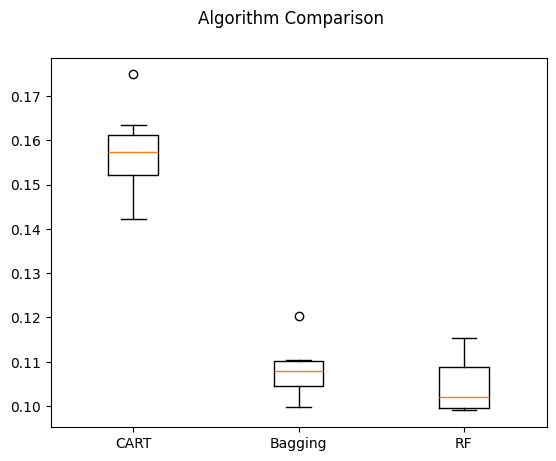

In [25]:
#Plot distribution of k-fold MSE for the 3 models
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_mse)
ax.set_xticklabels(names_c)
plt.show()

LR: 0.098091 (0.005110)


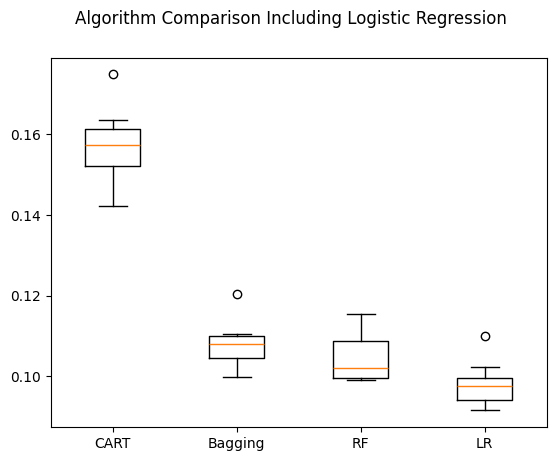

In [26]:
#Initialize the logistic regression model
logreg = LogisticRegression(penalty='l2', C=1.0, random_state=42)

#Define the cross-validation method
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

#Calculate the cross-validation mean squared error for the logistic regression model
logreg_cv_results = cross_val_score(logreg, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

#Add the results of the logistic regression to the results list
results_mse.append(-logreg_cv_results)
names_c.append('LR')

#Print the average MSE and standard deviation for the logistic regression
msg = "LR: %f (%f)" % (-logreg_cv_results.mean(), logreg_cv_results.std())
print(msg)

#Continue plotting using the existing figure object
fig = plt.figure()
fig.suptitle('Algorithm Comparison Including Logistic Regression')
ax = fig.add_subplot(111)
plt.boxplot(results_mse)
ax.set_xticklabels(names_c)
plt.show()

In [27]:
#Compare the 4 models out-of-sample performance, with the same 70/30 split
models = [
    ('CART', DecisionTreeClassifier(random_state=42)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)),
    ('LR', LogisticRegression(random_state=42))

]

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print(f'{name} Performance：AUC={auc_score:.2f}, Precison={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}')

CART Performance：AUC=0.64, Precison=0.34, Recall=0.36, F1=0.35
RF Performance：AUC=0.78, Precison=0.58, Recall=0.29, F1=0.38
Bagging Performance：AUC=0.76, Precison=0.55, Recall=0.29, F1=0.38
LR Performance：AUC=0.80, Precison=0.70, Recall=0.22, F1=0.33


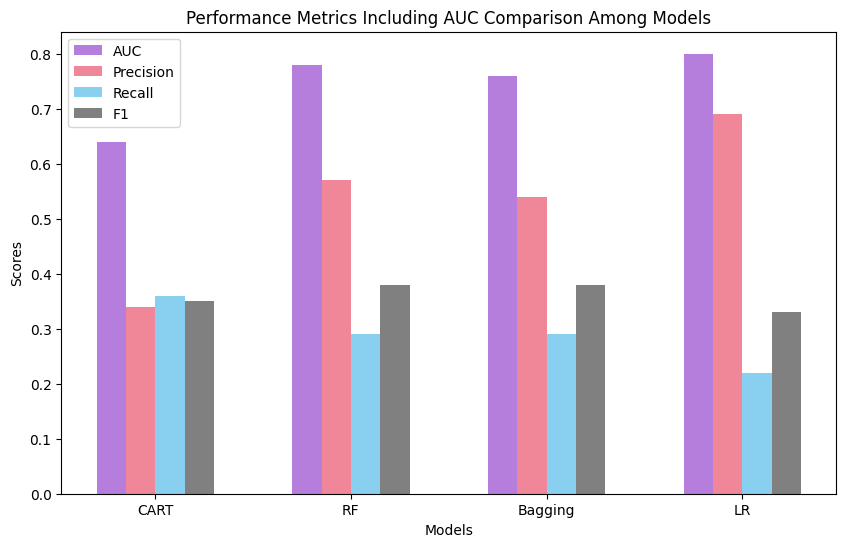

In [28]:
#Including AUC in the performance metrics for each model for plotting
model_metrics = {
    'CART': {'AUC': 0.64, 'Precision': 0.34, 'Recall': 0.36, 'F1': 0.35},
    'RF': {'AUC': 0.78, 'Precision': 0.57, 'Recall': 0.29, 'F1': 0.38},
    'Bagging': {'AUC': 0.76, 'Precision': 0.54, 'Recall': 0.29, 'F1': 0.38},
    'LR': {'AUC': 0.80, 'Precision': 0.69, 'Recall': 0.22, 'F1': 0.33}
}
index = np.arange(len(model_metrics))

#Adding AUC to the metrics list
metrics = ['AUC', 'Precision', 'Recall', 'F1']
metrics_data = {metric: [model_metrics[model][metric] for model in model_metrics] for metric in metrics}

#Redefine colors including one for AUC
colors = ['#B57EDC', '#F08799', '#89CFF0', '#808080']  # Purple, pink, blue, gray for AUC, Precision, Recall, F1

#Plotting the updated chart with AUC
fig, ax = plt.subplots(figsize=(10, 6))

#Adjust bar width for four metrics
bar_width = 0.15

#Plot each metric in a bar chart with different colors
for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, metrics_data[metric], bar_width, label=metric, color=colors[i])

#Add text and labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Including AUC Comparison Among Models')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(model_metrics.keys())
ax.legend()
plt.show()

## Part 4: Use unsupervised learning to find clusters in the data (PCA and K-means clustering)

In [29]:
#Reload the data and perform same transformation as in the beginning but this time all variabels get scaled in next cell
data = pd.read_csv('European_bank_marketing.csv')
data = data.drop_duplicates()
data = data.drop(columns=['emp.var.rate','nr.employed','cons.price.idx','duration'])

#Removing rows with 'unknown' values in specific columns
unknown_indices = data[(data['loan'] == 'unknown') | (data['housing'] == 'unknown') | (data['marital'] == 'unknown')].index
data = data.drop(index=unknown_indices)

#Show the shape of the dataset after removals
data.shape

#Search all the 'unknown' value
unknown_indexes = data[data['default'] == 'unknown'].index

if len(unknown_indexes) > 0:
    data.at[unknown_indexes[0], 'default'] = 'yes'
    data.loc[unknown_indexes[1:], 'default'] = 'no'

data['default'].value_counts()

#Correcting the provided code with proper Python syntax for mapping
data['contact'] = data['contact'].map({'cellular': 1, 'telephone': 0})
data['housing'] = data['housing'].map({'yes': 1, 'no': 0})
data['loan'] = data['loan'].map({'yes': 1, 'no':0})
data['default'] = data['default'].map({'yes': 1, 'no':0})

#Replace 999 in 'pdays' with 0, indicating no previous contact
data['pdays'] = data['pdays'].replace(999, 0)

#Convert 'previous' to a binary indicator where 1 indicates there was a contact and 0 otherwise
data['previous'] = data['previous'].apply(lambda x: 1 if x > 0 else 0)

#Map 'poutcome' to a binary indicator where 1 indicates success and 0 otherwise (including 'nonexistent' and 'failure')
data['poutcome'] = data['poutcome'].map({'nonexistent': 0, 'failure': 0, 'success': 1})

#Get dummie variables
data = pd.concat([data, pd.get_dummies(data['job'], prefix='job')], axis=1)
data = pd.concat([data, pd.get_dummies(data['month'], prefix='month')], axis=1)
data = pd.concat([data, pd.get_dummies(data['day_of_week'], prefix='day_of_week')], axis=1)
data = pd.concat([data, pd.get_dummies(data['education'], prefix='day_of_week')], axis=1)
data = pd.concat([data, pd.get_dummies(data['marital'], prefix='marital')], axis=1)

#Delete all the onehot encode original columns
columns_already_encoded = ['job', 'month', 'day_of_week', 'education','marital']
data_final = data.drop(columns=columns_already_encoded, errors='ignore')

In [30]:
data_final.shape

(40109, 51)

Best number of PCA components: 3


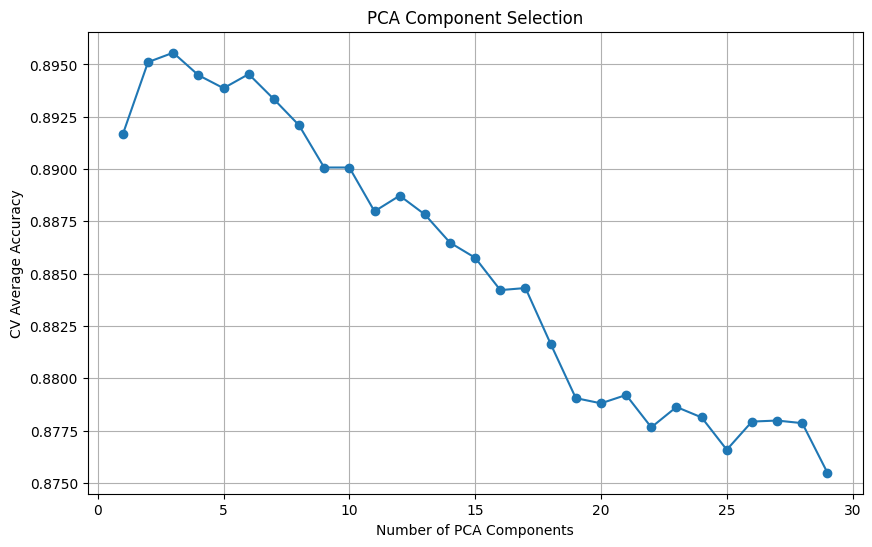

In [31]:
#Define the features and the target
X = data_final.drop('term_deposit', axis=1)
y = data_final['term_deposit']

#Create a scaler
scaler = StandardScaler()

#Scale the X data
X_scaled = scaler.fit_transform(X)

#Try different numbers of PCA components
n_components = np.arange(1, 30)  # From 1 to 29 components
mean_scores = []

for n in n_components:
    pca = PCA(n_components=n)
    logistic = LogisticRegression(max_iter=1000)
    pipeline = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    
    #Evaluate model performance using cross-validation
    scores = cross_val_score(pipeline, X_scaled, y, cv=5, scoring='accuracy')
    mean_scores.append(np.mean(scores))

#Find the best number of PCA components
best_n_components = n_components[np.argmax(mean_scores)]

#Print the best number of PCA components
print("Best number of PCA components:", best_n_components)

#Plot the relationship between the number of PCA components and the model's average accuracy
plt.figure(figsize=(10, 6))
plt.plot(n_components, mean_scores, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('CV Average Accuracy')
plt.title('PCA Component Selection')
plt.grid(True)
plt.show()

Total explained variance by the first three components: 0.94


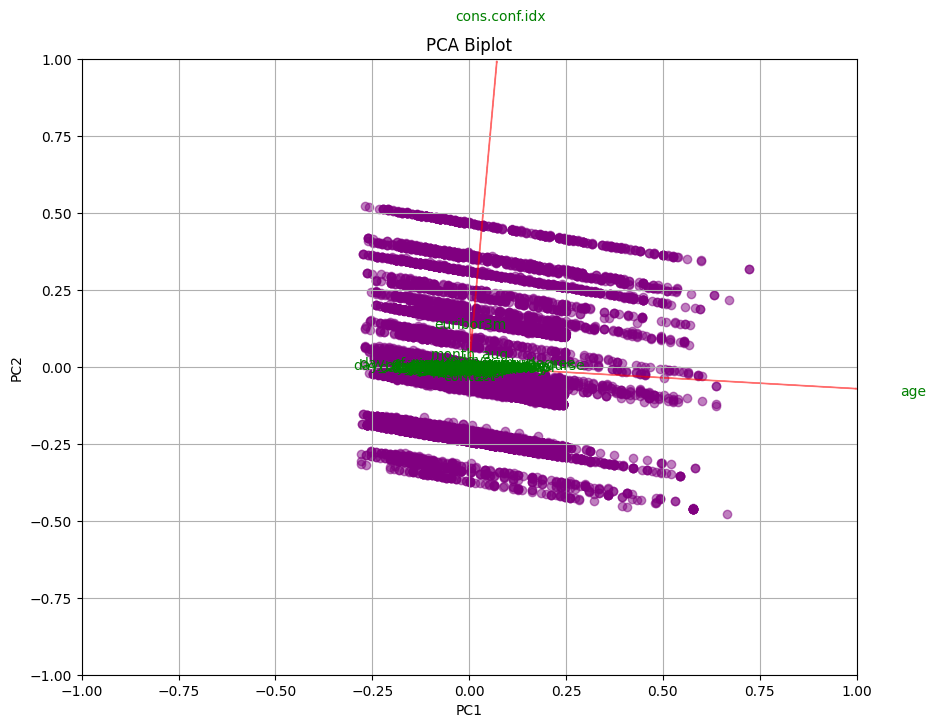

In [32]:
#Apply PCA directly on the non-standardized data
pca_model = PCA(n_components=3)
X_pca = pca_model.fit_transform(X)
explained_variance = np.cumsum(pca_model.explained_variance_ratio_)

#Add PCA results back to the original DataFrame
for i in range(X_pca.shape[1]):
    data_final[f'pca_{i+1}'] = X_pca[:, i]

#Print explained variance by the first three components
print(f"Total explained variance by the first three components: {explained_variance[2]:.2f}")

#Biplot function for 2D (we keep this as it is for simplicity and clarity)
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.figure(figsize=(10, 8))
    plt.scatter(xs * scalex, ys * scaley, c='purple', alpha=0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Biplot")
    plt.grid()
    plt.show()

# Plotting the biplot
biplot(X_pca[:,0:2], np.transpose(pca_model.components_[0:2, :]), labels=X.columns)

In [33]:
PCA = data_final[['pca_1','pca_2','pca_3','term_deposit']]
PCA.head()

,pca_1,pca_2,pca_3,term_deposit
0,16.241667,3.097996,-1.404127,0
1,17.224242,3.021195,-1.405503,0
2,-2.717721,4.439286,-1.392647,0
3,0.275858,4.239135,-1.390844,0
4,16.226884,3.091329,-1.403953,0


In [34]:
#Retrieve the components of the PCA model (i.e., the eigenvectors)
components = pca_model.components_

#Calculate the feature importances (sum of squared loadings of each feature across all principal components)
feature_importances = np.sum(components**2, axis=0)

#Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

#Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#Display the sorted feature importances
print(feature_importance_df[:15])

                          Feature  Importance
0                             age    0.999248
9                   cons.conf.idx    0.982384
5                        campaign    0.977135
10                      euribor3m    0.034152
6                           pdays    0.001985
25                      month_aug    0.001187
4                         contact    0.001157
27                      month_jul    0.000497
24                      month_apr    0.000382
7                        previous    0.000380
49                 marital_single    0.000325
48                marital_married    0.000174
28                      month_jun    0.000140
31                      month_nov    0.000084
45  day_of_week_university.degree    0.000081


In [35]:
X = data_final[['pca_1', 'pca_2', 'pca_3']]
y = data_final['term_deposit']

#Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Initialize models
models = [
    ('CART', DecisionTreeClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('LR', LogisticRegression(random_state=42))
]


results_mse = []
names_c = []

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_mse.append(-cv_results)
    names_c.append(name)
    msg = "%s: %f (%f)" % (name, -cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.154723 (0.006839)
Bagging: 0.114618 (0.005327)
RF: 0.113514 (0.005848)
LR: 0.111092 (0.006759)


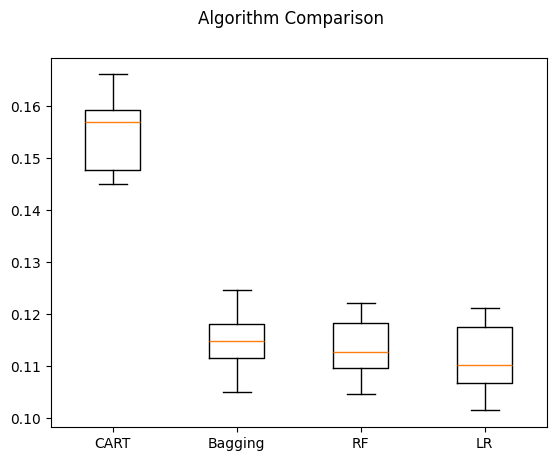

In [36]:
#Continue plotting using the existing figure object
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_mse)
ax.set_xticklabels(names_c)
plt.show()

In [37]:
#Calculate AUC, Precision, Recall, F1 with PCA inputs
models = [
    ('CART', DecisionTreeClassifier(random_state=42)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)),
    ('LR', LogisticRegression(random_state=42))

]

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print(f'{name}Performance：AUC={auc_score:.2f}, Precison={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}')

CARTPerformance：AUC=0.61, Precison=0.32, Recall=0.31, F1=0.31
RFPerformance：AUC=0.75, Precison=0.48, Recall=0.25, F1=0.33
BaggingPerformance：AUC=0.72, Precison=0.48, Recall=0.24, F1=0.32
LRPerformance：AUC=0.62, Precison=0.00, Recall=0.00, F1=0.00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


k=2, Silhouette Score: 0.3129
k=3, Silhouette Score: 0.3192
k=4, Silhouette Score: 0.3509
k=5, Silhouette Score: 0.3540
k=6, Silhouette Score: 0.3634
k=7, Silhouette Score: 0.3481
k=8, Silhouette Score: 0.3544
k=9, Silhouette Score: 0.3535
k=10, Silhouette Score: 0.3148


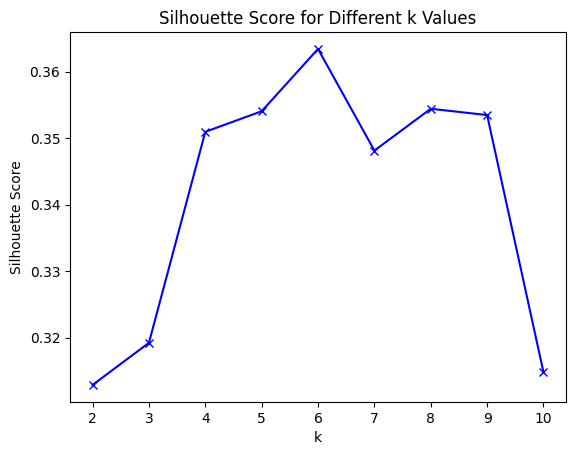

The optimal k value is: 6


In [38]:
#Standardized data after scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Test different values of k to find the one with the highest silhouette score
silhouette_scores = []
ks = range(2, 11)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'k={k}, Silhouette Score: {silhouette_avg:.4f}')

#Visualize silhouette scores for different values of k
plt.figure()
plt.plot(ks, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k Values')
plt.show()

#Choose the k value with the highest silhouette score
optimal_k = ks[silhouette_scores.index(max(silhouette_scores))]
print(f'The optimal k value is: {optimal_k}')

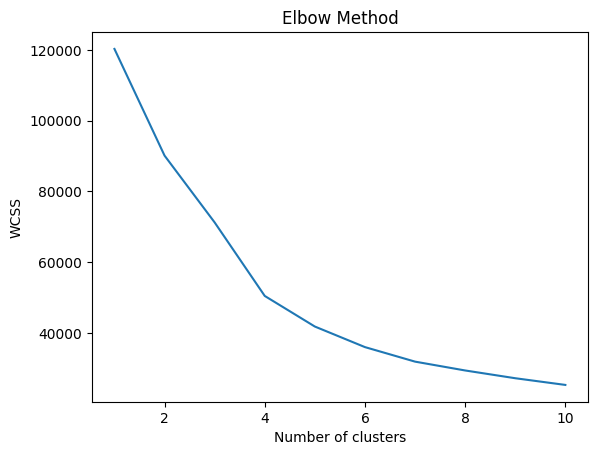

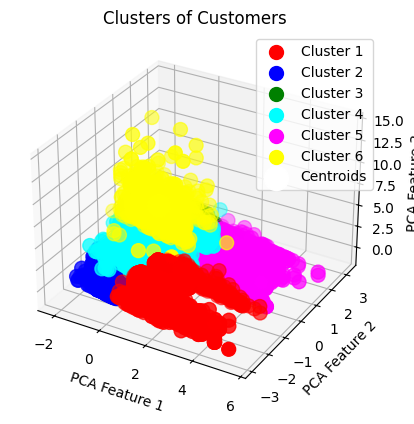

In [39]:
#Assuming X is the dataset after PCA containing three principal components
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Using the Elbow method to determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

#Plotting the Elbow chart
plt.figure()
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#Optimal number of clusters chosen based on the Elbow chart
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

#Visualizing clustering results (3D)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']
for i in range(optimal_clusters):
    ax.scatter(X_scaled[cluster_labels == i, 0], X_scaled[cluster_labels == i, 1], X_scaled[cluster_labels == i, 2], s=100, c=colors[i], label=f'Cluster {i+1}')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='white', label='Centroids')
ax.set_title('Clusters of Customers')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')
ax.legend()
plt.show()

In [40]:
#KMeans Model
kmeans_model = KMeans(n_clusters=6) 
kmeans_model.fit(X)

KMeans(n_clusters=6)

In [41]:
data_final['cluster_labels'] = kmeans_model.labels_

In [42]:
X = data_final[['pca_1', 'pca_2', 'pca_3', 'cluster_labels']]
y = data_final['term_deposit']

#Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Initialize models

models = [
    ('CART', DecisionTreeClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('LR', LogisticRegression(random_state=42))
]

results_mse = []
names_c = []

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_mse.append(-cv_results)
    names_c.append(name)
    msg = "%s: %f (%f)" % (name, -cv_results.mean(), cv_results.std())
    print(msg)


CART: 0.156112 (0.005760)
Bagging: 0.114724 (0.004968)
RF: 0.112872 (0.005415)
LR: 0.111092 (0.006759)


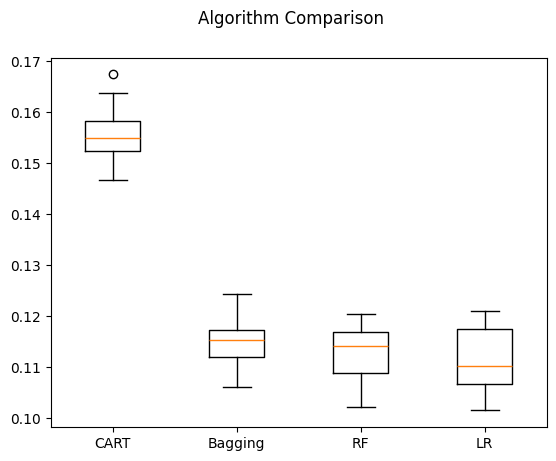

In [43]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_mse)
ax.set_xticklabels(names_c)
plt.show()

In [44]:
models = [
    ('CART', DecisionTreeClassifier(random_state=42)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)),
    ('LR', LogisticRegression(random_state=42))
]

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print(f'{name} Performance：AUC={auc_score:.2f}, Precison={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}')

CART Performance：AUC=0.61, Precison=0.31, Recall=0.31, F1=0.31
RF Performance：AUC=0.75, Precison=0.49, Recall=0.26, F1=0.34
Bagging Performance：AUC=0.71, Precison=0.47, Recall=0.24, F1=0.32
LR Performance：AUC=0.62, Precison=0.00, Recall=0.00, F1=0.00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
